In [1]:
import os
import librosa
from matplotlib import pyplot
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.models import load_model
from sklearn.metrics import ConfusionMatrixDisplay


warnings.filterwarnings("ignore")

2021-11-10 17:05:54.378585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-10 17:05:54.378633: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
labels=["eight", "four", "five", "three", "six"]

In [3]:
train_audio_path = '/home/wojtek/SG/speech_classification/'

all_wave = []
all_label = []
for label in labels:
    #print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000): 
            all_wave.append(samples)
            all_label.append(label)

In [4]:
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [5]:
y=np_utils.to_categorical(y, num_classes=len(labels))

In [6]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [7]:
def predict(audio, model):
    indices = np.empty(len(y_val))
    e = 0
    for i in audio:
        prob=model.predict(i.reshape(-1,8000,1))
        index=np.argmax(prob[0])
        indices[e]=index
        e += 1
    return indices

2021-11-10 17:09:30.873519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-10 17:09:30.879708: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-10 17:09:30.880704: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wojtek): /proc/driver/nvidia/version does not exist
2021-11-10 17:09:30.884548: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-10 17:09:31.271352: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 55136000 exceeds 10%


Macierz pomylek dla zbioru treningowego 1723 oraz zbioru walidacyjnego 431: 



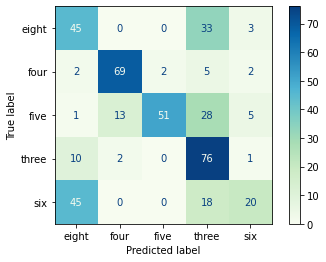


Precyzja dla zbioru treningowego 1723 oraz zbioru walidacyjnego 431: 0.6681494433156087

Pelnosc dla zbioru treningowego 1723 oraz zbioru walidacyjnego 431: 0.6066720317024423

F1 dla zbioru treningowego 1723 oraz zbioru walidacyjnego 431: 0.5934818996418413


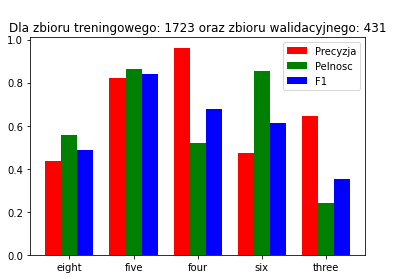

In [8]:
import logging
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.get_logger().setLevel(logging.ERROR)

x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)
precision_summary = []
recall_summary = []
f1_summary = []
    
K.clear_session()
inputs = Input(shape=(8000,1))
#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
#Flatten layer
conv = Flatten()(conv)
#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)
#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)
outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
#model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, min_delta=0.0001) 
directory = '/home/wojtek/SG/'
name = 'best_model99.hdf5'
mc = ModelCheckpoint(name, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
model.save(directory + name)

x_tr = x_train[:len(x_train)//5]
y_tr = y_train[:len(x_train)//5]
x_val = x_valid[:len(x_valid)//5]
y_val = y_valid[:len(x_valid)//5]
history = model.fit(x_tr, y_tr ,epochs=10, verbose=0, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))
y_pred = predict(x_val, model)
y_val_max = np.argmax(y_val, axis=1)

confmat = confusion_matrix(y_true=y_val_max, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=labels)
disp = disp.plot(include_values=True, cmap='GnBu', ax=None, xticks_rotation='horizontal')
print("\nMacierz pomylek dla zbioru treningowego {} oraz zbioru walidacyjnego {}: \n".format(len(x_train)//5, len(x_valid)//5))
plt.show()

precision_macro = precision_score(y_true=y_val_max, y_pred=y_pred, average='macro')
precision_summary.append(precision_macro)
recall_macro = recall_score(y_true=y_val_max, y_pred=y_pred, average='macro')
recall_summary.append(recall_macro)
f1_macro = f1_score(y_true=y_val_max, y_pred=y_pred, average='macro')
f1_summary.append(f1_macro)
print("\nPrecyzja dla zbioru treningowego {} oraz zbioru walidacyjnego {}: {}".format(len(x_train)//5, len(x_valid)//5, precision_macro))
print("\nPelnosc dla zbioru treningowego {} oraz zbioru walidacyjnego {}: {}".format(len(x_train)//5, len(x_valid)//5, recall_macro))
print("\nF1 dla zbioru treningowego {} oraz zbioru walidacyjnego {}: {}".format(len(x_train)//5, len(x_valid)//5, f1_macro))

precision = precision_score(y_true=y_val_max, y_pred=y_pred, average=None)
recall = recall_score(y_true=y_val_max, y_pred=y_pred, average=None)
f1 = f1_score(y_true=y_val_max, y_pred=y_pred, average=None)

barWidth = 0.25
fig = plt.figure()
br1 = np.arange(len(precision))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
plt.bar(br1, precision, color='r', width=barWidth, label='Precyzja')
plt.bar(br2, recall, color='g', width=barWidth, label='Pelnosc')
plt.bar(br3, f1, color='b', width=barWidth, label='F1')
plt.xticks([r+barWidth for r in range(len(precision))], [classes[0], classes[1], classes[2], classes[3], classes[4]]) 
plt.legend()
plt.title("\nDla zbioru treningowego: {} oraz zbioru walidacyjnego: {}".format(len(x_train)//5, len(x_valid)//5))
plt.show()

2021-11-10 17:10:59.953585: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 55136000 exceeds 10% of free system memory.



Macierz pomylek dla zbioru treningowego 1723 oraz zbioru walidacyjnego 431: 



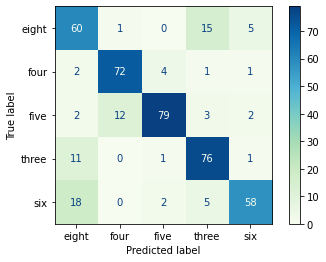


Precyzja dla zbioru treningowego 1723 oraz zbioru walidacyjnego 431: 0.8072992813611656

Pelnosc dla zbioru treningowego 1723 oraz zbioru walidacyjnego 431: 0.7999181909425774

F1 dla zbioru treningowego 1723 oraz zbioru walidacyjnego 431: 0.7997288469762233


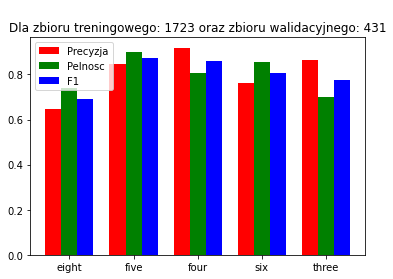

In [9]:
precision_summary = []
recall_summary = []
f1_summary = []
path = '/home/wojtek/SG/'

K.clear_session() 
model = load_model(path + 'best_model0.hdf5')
#model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, min_delta=0.0001) 
directory = '/home/wojtek/SG/'
name = 'best_model100.hdf5'
mc = ModelCheckpoint(name, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
model.save(directory + name)

x_tr = x_train[:len(x_train)//5]
y_tr = y_train[:len(x_train)//5]
x_val = x_valid[:len(x_valid)//5]
y_val = y_valid[:len(x_valid)//5]
history = model.fit(x_tr, y_tr ,epochs=10, verbose=0, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))
y_pred = predict(x_val, model)
y_val_max = np.argmax(y_val, axis=1)

confmat = confusion_matrix(y_true=y_val_max, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=labels)
disp = disp.plot(include_values=True, cmap='GnBu', ax=None, xticks_rotation='horizontal')
print("\nMacierz pomylek dla zbioru treningowego {} oraz zbioru walidacyjnego {}: \n".format(len(x_train)//5, len(x_valid)//5))
plt.show()

precision_macro = precision_score(y_true=y_val_max, y_pred=y_pred, average='macro')
precision_summary.append(precision_macro)
recall_macro = recall_score(y_true=y_val_max, y_pred=y_pred, average='macro')
recall_summary.append(recall_macro)
f1_macro = f1_score(y_true=y_val_max, y_pred=y_pred, average='macro')
f1_summary.append(f1_macro)
print("\nPrecyzja dla zbioru treningowego {} oraz zbioru walidacyjnego {}: {}".format(len(x_train)//5, len(x_valid)//5, precision_macro))
print("\nPelnosc dla zbioru treningowego {} oraz zbioru walidacyjnego {}: {}".format(len(x_train)//5, len(x_valid)//5, recall_macro))
print("\nF1 dla zbioru treningowego {} oraz zbioru walidacyjnego {}: {}".format(len(x_train)//5, len(x_valid)//5, f1_macro))

precision = precision_score(y_true=y_val_max, y_pred=y_pred, average=None)
recall = recall_score(y_true=y_val_max, y_pred=y_pred, average=None)
f1 = f1_score(y_true=y_val_max, y_pred=y_pred, average=None)

barWidth = 0.25
fig = plt.figure()
br1 = np.arange(len(precision))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
plt.bar(br1, precision, color='r', width=barWidth, label='Precyzja')
plt.bar(br2, recall, color='g', width=barWidth, label='Pelnosc')
plt.bar(br3, f1, color='b', width=barWidth, label='F1')
plt.xticks([r+barWidth for r in range(len(precision))], [classes[0], classes[1], classes[2], classes[3], classes[4]]) 
plt.legend()
plt.title("\nDla zbioru treningowego: {} oraz zbioru walidacyjnego: {}".format(len(x_train)//5, len(x_valid)//5))
plt.show()